In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa, pcoa_biplot
import umap
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import seaborn as sns
import scipy.io as sio
import scipy
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from IPython.display import display, HTML
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys  
sys.path.insert(0, '../my_packages')
import dimen_reduc
import meta_ord
import paga_res
import sliding_window
import statistic

#### Variables

In [3]:
top_path = "C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/"
    
file_name = top_path + 'all_df_26062023.xlsx'
sheet_abun = 'abundance'
sheet_meta = 'meta'

date = '02072023'

# in_path = top_path + 'in_df_16052023.xlsx'
# out_path = top_path + 'out_df_16052023.xlsx'

#### Load data

In [5]:
df = pd.read_excel(file_name, sheet_name = sheet_abun, index_col = 0)
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
display(df.shape)
display(meta.shape)

(8541, 32)

#### Remove rare species and order

In [65]:
def remove_rare_species(df, prevalence_cutoff = 0.1, avg_abundance_cutoff = 0.005):
    filt_df = df.copy()
    n_samples = df.shape[0]
    n_taxa_before_filter = df.shape[1]
    
    # Prevalence calculations (number of non-zero values per feature)
    frequencies = (df > 0).sum(axis = 0) / n_samples
    filt_df = filt_df.loc[:,frequencies > prevalence_cutoff]
    
    # Average abundance calculations
    avg_abundances = df.sum(axis = 0) / n_samples
    filt_df = filt_df.loc[:, avg_abundances > avg_abundance_cutoff]
    
    # Order
    s = filt_df.sum()
    filt_df = filt_df[s.sort_values(ascending = False).index]
    
    return filt_df

In [68]:
filt_df = remove_rare_species(df, prevalence_cutoff = 0.00001, avg_abundance_cutoff = 0.00005)
print(filt_df.shape)

(8541, 373)


#### Separate to included and excluded samples

In [70]:
random.seed(111)
percent_num = 0.08
## UAB subjects
num_temp_lst = meta.loc[meta['db'].isin(['temp_hiseq', 'temp_pyro'])]['subjectID'].unique().tolist()
subj_temp_lst = random.sample(num_temp_lst, 12)

## PVI subjects
# num_pvi_lst = meta.loc[meta['db'].isin(['carter'])]['subjectID'].unique().tolist()
# subj_pvi_lst = random.sample(num_pvi_lst, int(len(num_pvi_lst) * percent_num))

## AVPVC subjects
all_cros_II_subj = meta.loc[meta['db'] == 'cros_II']['subjectID'].tolist()
subj_cros_lst = random.sample(all_cros_II_subj, int(len(all_cros_II_subj) * percent_num))

## PHS subjects
# all_srin_subj = meta.loc[meta['db'] == 'srin']['subjectID'].tolist()
# subj_srin_lst = random.sample(all_cros_II_subj, int(len(all_srin_subj) * percent_num))

both_subj_lst = subj_temp_lst + subj_cros_lst #+ subj_pvi_lst + subj_srin_lst
print('Number of excluded subjects in UAB: ', len(subj_temp_lst))
print('Number of excluded subjects in AVPVC: ', len(subj_cros_lst))
# print('Number of excluded subjects in PVI: ', len(subj_pvi_lst))
# print('Number of excluded subjects in PHS: ', len(subj_srin_lst))

Number of excluded subjects in UAB:  12
Number of excluded subjects in AVPVC:  30


In [71]:
in_meta = meta[~meta.subjectID.isin(both_subj_lst)]
out_meta = meta[meta.subjectID.isin(both_subj_lst)]
print('Origin row number: ' + str(meta.shape[0]))
print('Origin number of subjectID: ' + str(len(meta.subjectID.unique())))
print('In_meta (after removal of out samples) row number: ' + str(in_meta.shape[0]))
print('In_meta (after removal of out samples) number of subjectID: ' + str(len(in_meta.subjectID.unique())))
print('Out_meta (the samples removed) row number: ' + str(out_meta.shape[0]))
print('Out_meta (the samples removed) number of subjectID: ' + str(len(out_meta.subjectID.unique())))

in_df = filt_df.loc[in_meta.index]
out_df = filt_df.loc[out_meta.index]
print('In_df row number: ' + str(in_df.shape[0]))
print('Out_df row number: ' + str(out_df.shape[0]))

Origin row number: 8541
Origin number of subjectID: 553
In_meta (after removal of out samples) row number: 8026
In_meta (after removal of out samples) number of subjectID: 511
Out_meta (the samples removed) row number: 515
Out_meta (the samples removed) number of subjectID: 42
In_df row number: 8026
Out_df row number: 515


In [72]:
in_meta['sampleID'].fillna(in_meta.index.to_series(), inplace = True)
in_meta.groupby('db')['sampleID'].count()

db
carter         495
cros_I        3879
cros_II        355
srin           185
temp_hiseq    1803
temp_pyro     1309
Name: sampleID, dtype: int64

In [85]:
in_meta['root'] = np.where((in_meta['BV_bin'] == 1) & (in_meta['shannon_index'] > 3.5), 'root', 'reg')#in_meta.apply(lambda row: get_label(row), axis = 1)

In [86]:
print(in_meta.groupby(['root'])['sampleID'].count())
print(in_meta[in_meta['root'] == 'root'].groupby('subCST')['sampleID'].count())

root
reg     8005
root      21
Name: sampleID, dtype: int64
subCST
III-B     1
IV-A      1
IV-B     17
IV-C0     2
Name: sampleID, dtype: int64


In [87]:
## Save
in_dict = {'abundance': in_df, 'meta': in_meta}
out_dict = {'abundance': out_df, 'meta': out_meta}
in_path = top_path + '/in_df_' + str(date) + '.xlsx'
out_path = top_path + '/out_df_' + str(date) + '.xlsx'
paga_res.save_excel(in_path, in_dict)
paga_res.save_excel(out_path, out_dict)

#### Functions

In [88]:
n_neighbors_lst = [15,20, 25] # 
n_pcs_lst = [15, 20, 30, 50] #

def get_umap(andata, metric, rep, color = ['CST', 'subCST', 'db'], legend_loc = 'right margin', n_neighbors_lst = n_neighbors_lst, n_pcs_lst = n_pcs_lst, use_rep = True):
    umap_lst = []
    for n_neighbor in n_neighbors_lst:
        for n_pc in n_pcs_lst:
            if use_rep:
                sc.pp.neighbors(andata, n_neighbors = n_neighbor, n_pcs = n_pc, metric = metric, use_rep = rep)
            else:
                sc.pp.neighbors(andata, n_neighbors = n_neighbor, n_pcs = n_pc, metric = metric)
            sc.tl.draw_graph(andata)
            sc.pl.draw_graph(andata, color = color, legend_loc = legend_loc, 
                             title = 'n_neighbor: ' + str(n_neighbor) + ', ' + 'n_pc: ' + str(n_pc))
            
def get_umap_userep(andata, metric, rep, color = ['CST', 'subCST', 'db'], legend_loc = 'right margin', n_neighbors_lst = n_neighbors_lst, n_pc = 50, use_rep = True):
    umap_lst = []
    for n_neighbor in n_neighbors_lst:
        if use_rep:
            sc.pp.neighbors(andata, n_neighbors = n_neighbor, n_pcs = n_pc, metric = metric, use_rep = rep)
        else:
            sc.pp.neighbors(andata, n_neighbors = n_neighbor, n_pcs = n_pc, metric = metric)
        sc.tl.draw_graph(andata)
        sc.pl.draw_graph(andata, color = color, legend_loc = legend_loc, 
                         title = 'n_neighbor: ' + str(n_neighbor) + ', ' + 'n_pc: ' + str(n_pc))

In [89]:
def get_adata(df, meta, pca = True):
    ## Initialize adata
    adata = AnnData(X = df.to_numpy(),
                        obs = meta[['CST', 'subCST', 'db']],
                        var = pd.DataFrame(index = df.columns))
    
    if pca: 
        adata = AnnData(X = df.to_numpy(),
                        obs = meta[['CST', 'subCST', 'db']],
                        var = pd.DataFrame(index = df.columns),
                        uns = {'pca': {}})
    
    adata.X = adata.X.astype('float64')    
    
    return adata

In [90]:
def get_pca(adata, pca_df, pca_loadings, pca_variance_ratio, pca_variance):
    adata.obsm['X_pca'] = pca_df
    adata.varm['PCs'] = pca_loadings
    adata.uns['pca']['variance_ratio'] = pca_variance_ratio
    adata.uns['pca']['variance'] = pca_variance
    
    return adata

#### Create df for adata

In [ ]:
# Options:
# 1. BC based on original feature table (origin df)
# 2. UMAP based on centered PCA
# 3. UMAP based on BC PCOA (origin df) 
# 4. UMAP based on jaccard PCOA (origin df)?

In [91]:
center_df = dimen_reduc.get_center(in_df)
meta = meta.reindex(in_df.index)

In [92]:
# 1. BC based on original feature table (origin df)
orig_adata = get_adata(in_df, meta, pca = False)

In [93]:
# 2. UMAP based on centered PCA
c_pca_df, c_pca_loadings, c_pca_variance_ratio, c_pca_variance = dimen_reduc.get_pca_reg(center_df)
c_pca_adata = get_adata(center_df, meta, pca = True)
c_pca_adata = get_pca(c_pca_adata, c_pca_df, c_pca_loadings, c_pca_variance_ratio, c_pca_variance)

In [ ]:
# 3. UMAP based on BC PCOA (origin df) 
bc_dist_df = dimen_reduc.get_bc_dist(in_df)
bc_pcoa_df, bc_pcoa_loadings, bc_pcoa_variance_ratio, bc_pcoa_variance = dimen_reduc.get_pcoa(bc_dist_df, in_df, 'index')
pcoa_adata = get_adata(in_df, meta, pca = True)
pcoa_adata = get_pca(pcoa_adata, bc_pcoa_df, bc_pcoa_loadings[:in_df.shape[1]], bc_pcoa_variance_ratio, bc_pcoa_variance)

#### Try UMAP with different variables

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical


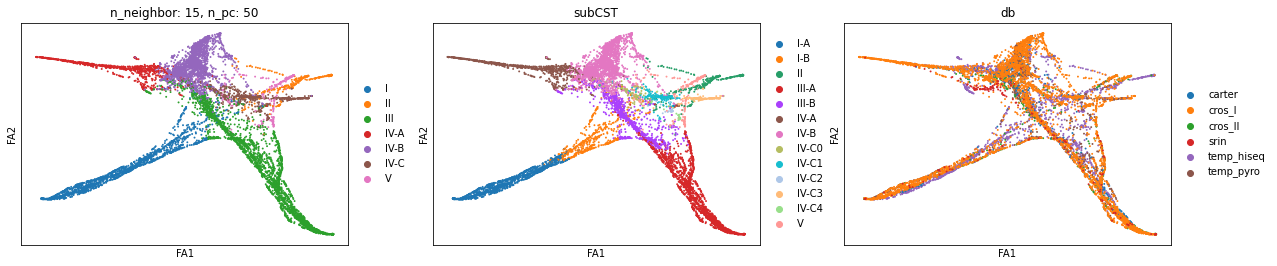

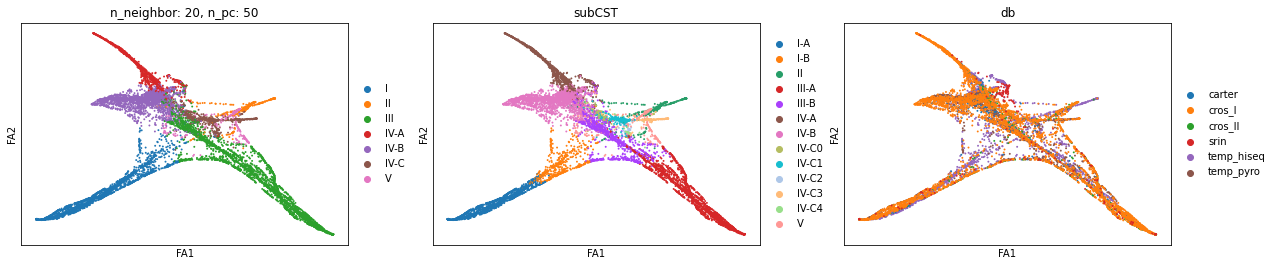

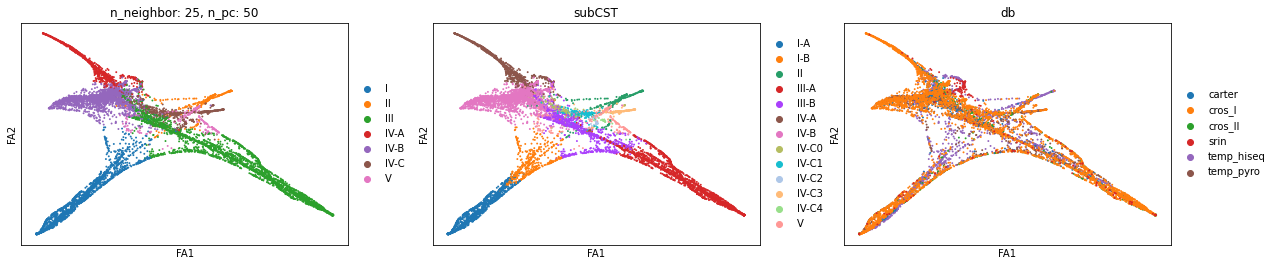

In [95]:
# 1. BC based on original feature table (origin df)
get_umap_userep(orig_adata, 'braycurtis', 'X', use_rep = True)

... storing 'CST' as categorical
... storing 'subCST' as categorical
... storing 'db' as categorical


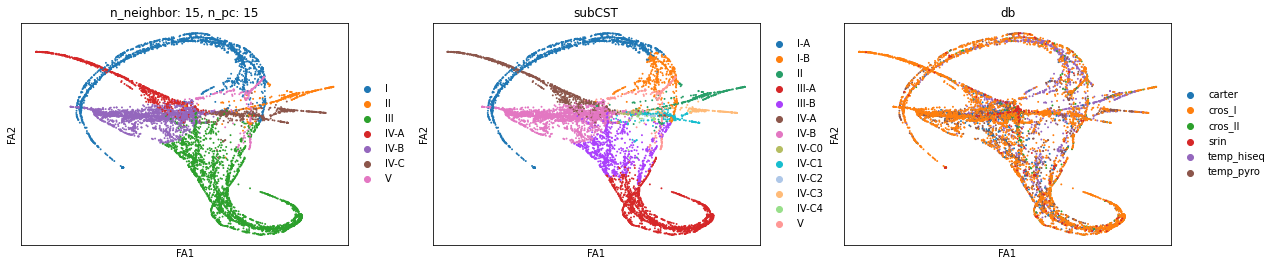

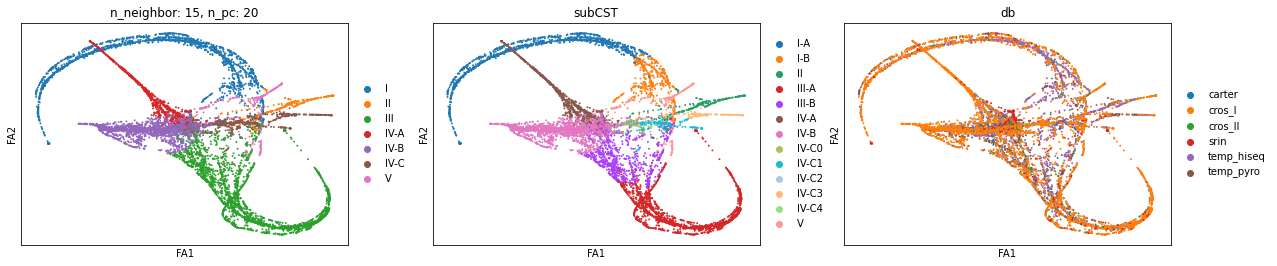

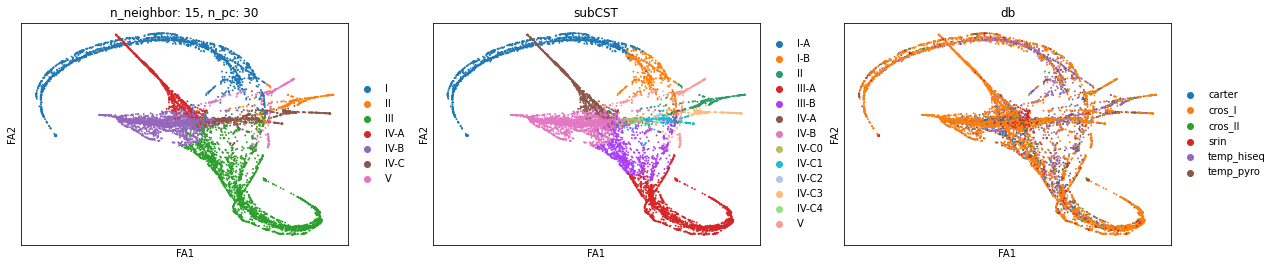

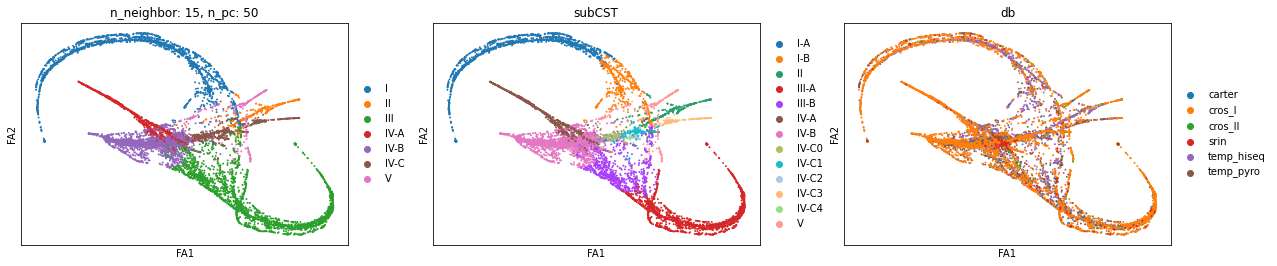

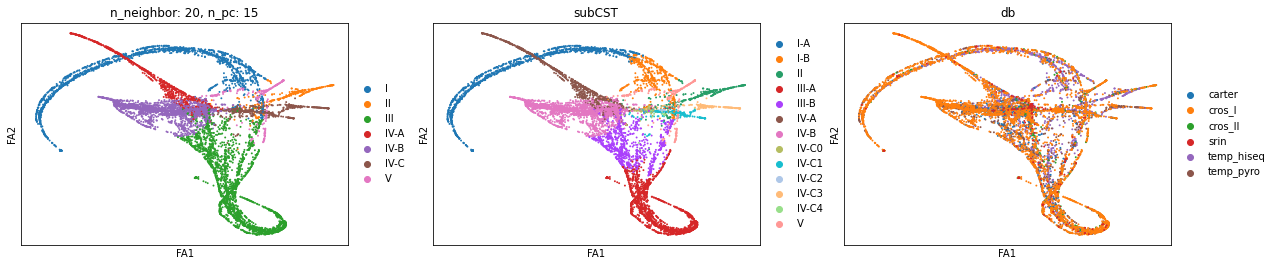

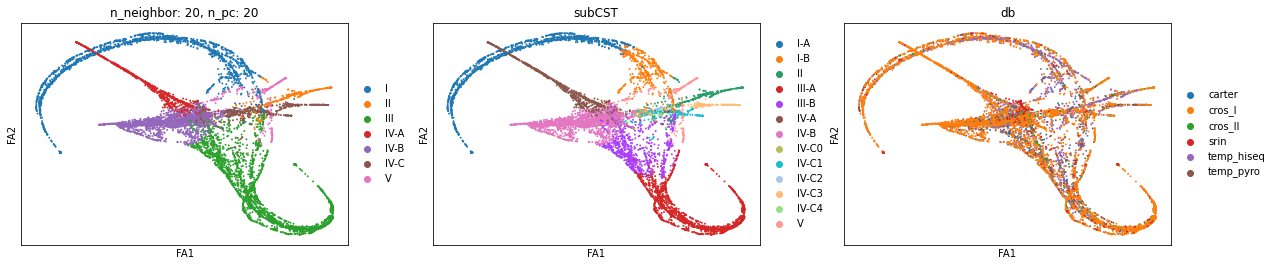

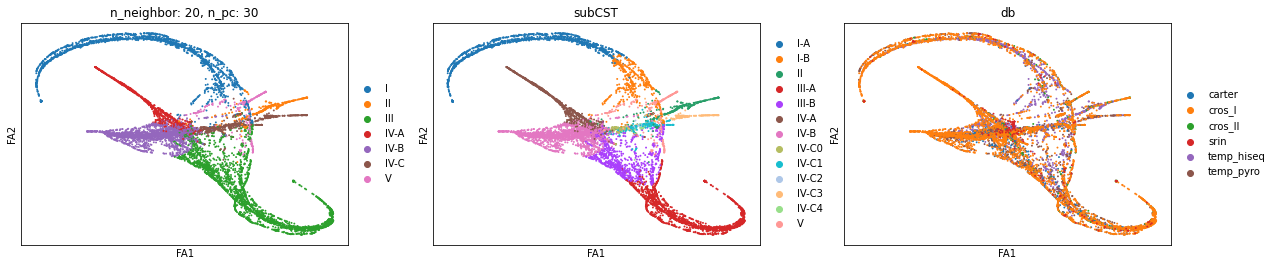

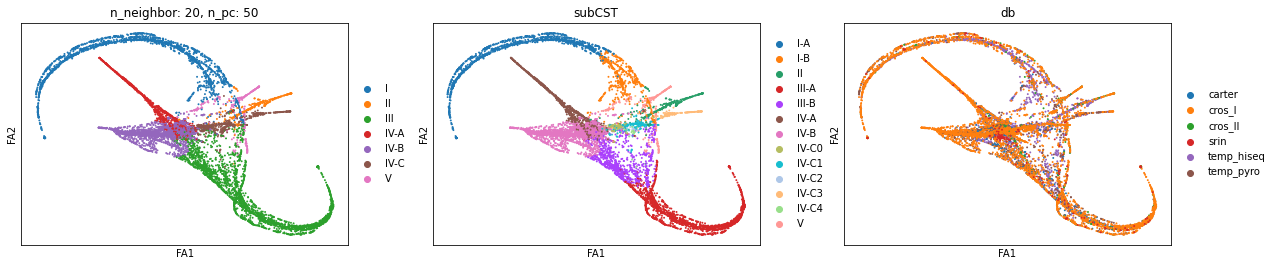

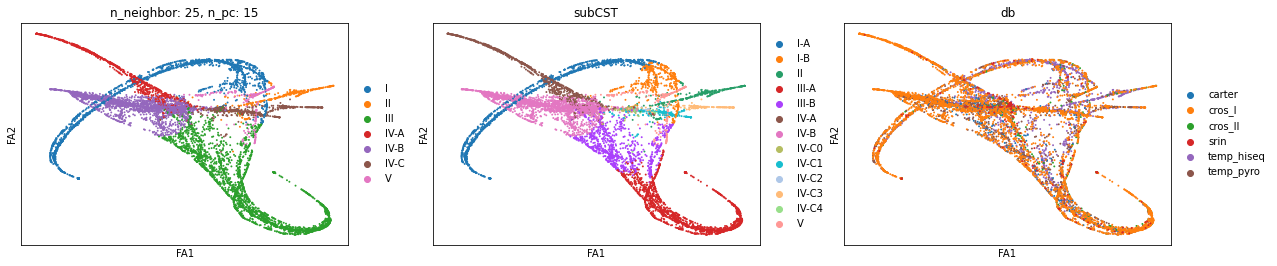

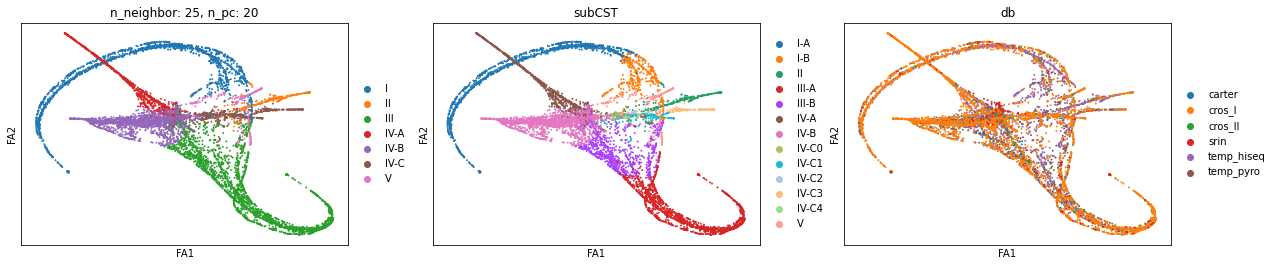

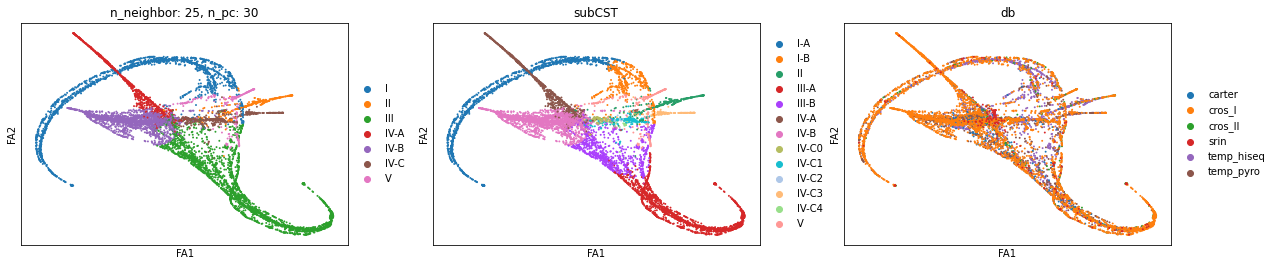

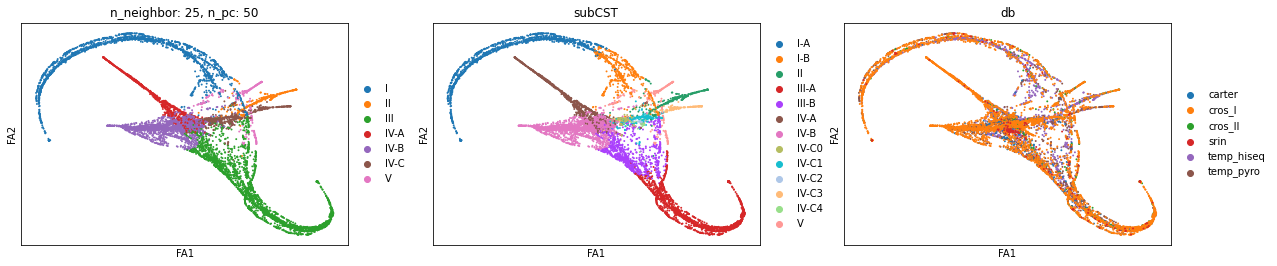

In [94]:
# 2. UMAP based on centered PCA
get_umap(c_pca_adata, 'euclidean', 'X', use_rep = False)

In [ ]:
# 3. UMAP based on BC PCOA (origin df) 
get_umap(pcoa_adata, 'braycurtis', 'X', use_rep = False)

In [ ]:
px.scatter(bc_pcoa_df.join(meta[['subCST', 'db', 'root']]), x = 'Axis.1', y = 'Axis.2', color = 'db', width = 20, height = 20)

In [33]:
c_pca_loadings.shape

(263, 50)